## Tutorial: mapping snRNAseq data on Visium data
by Gabriele Scalia (gscalia@broadinstitute.org) and Tommaso Biancalani (tbiancal@broadinstitute.org)
- Healthy adult mouse brain tissue from the primary visual area (VISp).
- snRNAseq data (SmartSeq2) and spatial data (Visium).

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [2]:
'Folder where data are stored'
fld = '.'
assert os.path.isdir(fld)

In [3]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'data/visp_sn_tpm_small_0430.h5ad')
adata = sc.read_h5ad(path)
adata.var_names_make_unique()

In [4]:
'Load spatial Visium data (AnnData format)'
path = os.path.join(fld, 'data/Allen1_cell_count.h5ad')
space_data = sc.read_h5ad(path)

In [5]:
'Restrict to non-empty voxels'
space_data = space_data[space_data.obs['cell_count'] > 0]

In [6]:
'Choose genes for mapping'
# Visium and snRNAseq datasets contains many shared genes: we choose a subset of relevant markers.
marker_genes = mapping.utils.read_pickle('data/spacejams_visp_markers.pkl')  # load marker list
markers_in_space_data = set(marker_genes) & set(space_data.var.index) 
space_data = space_data[:, list(markers_in_space_data)]

In [7]:
'Load cells coordinates on Visium image'
cells_coordinates = mapping.utils.read_pickle('data/Allen1_cell_centroids.pkl')

In [8]:
'Extract all cell positions'
cells_positions = []
idx_count = 0
for index,rows in space_data.obs.iterrows(): # Allen1_cell_counts adata
    for i in range (0,len(cells_coordinates)//4): # Allen1_cell_centroids.pkl
        if (rows['x_plot'], rows['y_plot']) == (cells_coordinates[i,1], cells_coordinates[i,0]):
            cell_centroid_array = cells_coordinates[i,3]
            idx_count += 1
            cells_positions.append(cell_centroid_array)
            break # so that loop does not iterate on the variable after it has found one match.
idx_count

158

In [9]:
'Compute shared genes between single nuclei and spatial data'
# get matched indices between prior (ie spatial data) and snRNA-seq adata
# `selected_genes` contains (ordered) shared genes'
mask_prior_indices, mask_adata_indices, selected_genes =  mapping.utils.get_matched_genes(
    space_data.var_names, adata.var_names
)
len(selected_genes)

1326

In [10]:
'create matrixes to run the algorithm'
S = np.array(adata[:, mask_adata_indices].X)
G = np.array(space_data[:, mask_prior_indices].X)
d = np.array(space_data.obs.cell_count)/space_data.obs.cell_count.sum()

In [11]:
'Apply log(1+x) to snRNAseq data (optional - we do not use that for Visium data)'
# S = np.log(1+S)

'Apply log(1+x) to snRNAseq data (optional - we do not use that for Visium data)'

In [12]:
'Select gpu/cpu for running Tangram'
device = torch.device('cuda:0')  # for gpu
# device = torch.device('cpu') # for cpu

In [13]:
'Define Tangram hyperparameters'
# refer to manuscript for their meaning
hyperparm = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
            'lambda_count' : 1, 'lambda_f_reg' : 1}

In [14]:
'Define training hyperparameters'
learning_rate = 0.1
num_epochs = 6000

In [15]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
mapper = mapping.mapping_optimizer.MapperConstrained(
    S=S, G=G, d=d, device=device, **hyperparm, target_count = space_data.obs.cell_count.sum()
)

In [16]:
'Train Tangram'
# Arguments: learning rate and the number of epochs.
# The output are the various loss terms (see manuscript)/
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (hyperaparamete)
output_all, F_out_all = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)

0.05782797932624817 0.43478986620903015 nan 5220.4853515625 2431.332275390625
0.010085925459861755 0.5960417985916138 nan 279.35443115234375 321.3817138671875
0.009874353185296059 0.5869247913360596 nan 1.2811279296875 319.9219970703125
0.010021217167377472 0.5823181867599487 nan 9.5572509765625 194.49615478515625
0.009970779530704021 0.5805399417877197 nan 0.84527587890625 157.91452026367188
0.00998133048415184 0.5789109468460083 nan 1.69415283203125 127.28282165527344
0.00995325855910778 0.5778278708457947 nan 1.8843994140625 108.84953308105469
0.010004066862165928 0.5773259997367859 nan 0.52789306640625 97.5645751953125
0.010040704160928726 0.5760819315910339 nan 2.104248046875 84.25098419189453
0.009961375035345554 0.5757200717926025 nan 0.6898193359375 78.30624389648438
0.009998765774071217 0.5746557712554932 nan 0.70379638671875 74.37516784667969
0.009986981749534607 0.5743294358253479 nan 1.5130615234375 64.50025939941406
0.01003844290971756 0.574363648891449 nan 1.649658203125 

In [17]:
output, F_out = output_all, F_out_all

In [18]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(adata.obs.subclass)
prob_assign = mapping.utils.transfer_annotations_prob_filter(output, F_out, df_classes)
prob_assign.head()

,L4,Vip,Lamp5,L5 NP,Sst,L5 IT,Oligo,L6 PT,L6 IT,Sncg,...,Astro,L5 PT,L6b,Endo,Peri,Meis2,Macrophage,CR,VLMC,SMC
0,0.000078,0.072221,0.212902,4.344472e-06,0.009510,0.000021,0.038007,0.000024,0.169535,0.013074,...,0.053394,0.000016,0.132938,0.007618,0.003561,1.689640e-04,0.171569,9.905610e-10,0.036791,0.002183
1,0.618136,0.387547,0.506554,3.184675e-06,0.557139,0.001108,0.030331,0.110179,0.243158,0.000024,...,0.159778,0.123847,0.000015,0.012638,0.000007,1.690785e-03,0.280567,9.518174e-10,0.030103,0.007604
2,0.188445,0.468939,0.668612,2.412960e-06,0.655828,0.021022,0.034825,0.018907,0.195767,0.057353,...,0.183411,0.145064,0.025490,0.034455,0.010545,5.181250e-07,0.035494,1.360275e-09,0.057187,0.006067
3,0.146933,2.787230,0.481858,8.637645e-07,0.000015,0.000005,0.000001,0.000006,0.410695,0.008378,...,0.094767,0.001636,0.000004,0.258241,0.057730,1.192166e-01,0.013639,9.069800e-10,0.109861,0.105942
4,0.488797,0.243796,0.823417,6.512264e-02,0.000023,0.000007,0.086031,0.080372,0.005255,0.054157,...,0.114198,0.167376,0.003585,0.070440,0.004188,1.040805e-02,0.050660,1.840534e-09,0.074858,0.000067


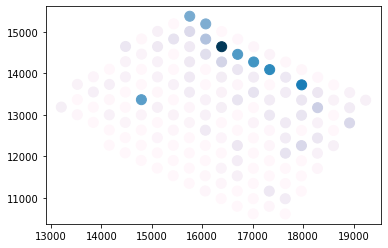

In [19]:
'Example: visualize spatial probability of cell type L6b'
plt.scatter(x=space_data.obs.x, y=space_data.obs.y, c=prob_assign['L6b'], s=100, cmap='PuBu');

**Deconvolution**

In [20]:
'Assign cell type to each spatial voxel'
# create a dataframe x, y, cell count for each voxel, and cell centroids for each voxel
df_vox_cells = pd.DataFrame({'x' : space_data.obs.x, 'y' : space_data.obs.y, 'cell_n' : space_data.obs.cell_count, 'centroids' : cells_positions})
# get the most probable voxel for each cell
resulting_voxels = np.argmax(output, axis=1)
# create a list with filtered cells and the voxels where they have been placed with the 
#highest probability a cell i is filtered if F_i > 0.5'
filtered_voxels_to_types = [(j, adata.obs.subclass[k]) for i, j, k in zip(F_out, resulting_voxels, range(len(adata))) if i > 0.5]
filtered_voxels_to_types[:5]

[(31, 'L4'), (105, 'L5 NP'), (144, 'L6 PT'), (103, 'Lamp5'), (139, 'L5 NP')]

For example: `[(109, 'Sst'), (96, 'Vip'), (33, 'Lamp5'), (44, 'Sst'), (102, 'Pvalb')]`
means that voxel 109 has a cell _Sst_, voxel 96 has a cell _Vip_, and so on. The length of `filtered_voxels_to_types` is equal to the number of mapped cells.

In [21]:
'Create a dataframe with the number of cell types in each voxel'
for index, i in enumerate(df_classes.columns):
    df_vox_cells[i] = 0
for k, v in filtered_voxels_to_types:
    df_vox_cells.iloc[k, df_vox_cells.columns.get_loc(v)] += 1

In [22]:
df_vox_cells.head()

,x,y,cell_n,centroids,L4,Vip,Lamp5,L5 NP,Sst,L5 IT,...,Astro,L5 PT,L6b,Endo,Peri,Meis2,Macrophage,CR,VLMC,SMC
CGCTGTGACGCCGCAC-1,13204,13187,1,"[[833, 826]]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATGCACTACCGCATTG-1,13838,12820,4,"[[802, 869], [810, 869], [811, 874], [812, 869]]",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAGATACTAACATAGT-1,13521,13003,4,"[[816, 852], [818, 851], [821, 852], [823, 854]]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GATCGACACTATCTGA-1,13839,13185,5,"[[828, 874], [829, 870], [831, 868], [833, 876...",0,3,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
ATAGAGTACTGGGACA-1,13522,13368,3,"[[836, 850], [836, 854], [845, 855]]",1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
'Assign cell types to coordinates'
cell_types_mapped = mapping.utils.df_to_cell_types(df_vox_cells, list(df_classes.columns))

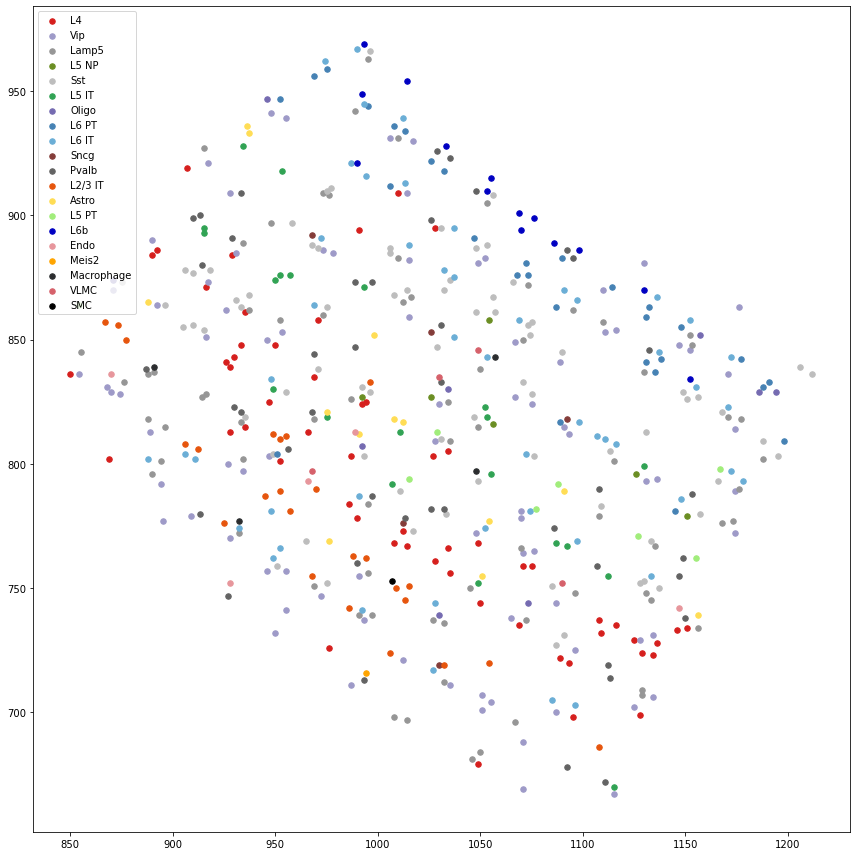

In [24]:
'Visualize all cells, using the colormap in the library'

plt.figure(figsize = (12,12))

for index, (k,v) in enumerate(cell_types_mapped.items()):
    if len(v) == 0:
        continue
    x_cells, y_cells = zip(*v)
    plt.scatter(y_cells, x_cells, s= 30, label=k, color=mapping.plot_utils.mapping_colors[k])
    
s_area = ((space_data.uns['spot_diameter_fullres']*space_data.uns['tissue_hires_scalef'])/2)**2

plt.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('all_types.png', dpi=300)

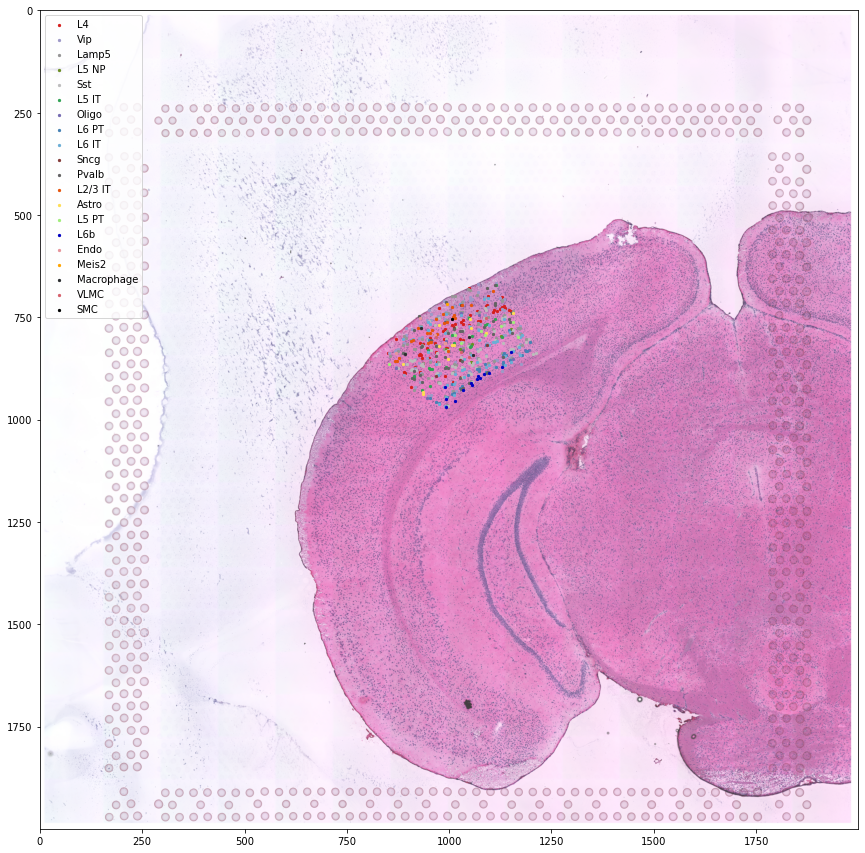

In [25]:
'Visualize all cells, using the colormap in the library'

plt.figure(figsize = (12,12))

plt.imshow(space_data.uns['image_hires'], alpha=0.8)

for index, (k,v) in enumerate(cell_types_mapped.items()):
    if len(v) == 0:
        continue
    x_cells, y_cells = zip(*v)
    plt.scatter(y_cells, x_cells, s=5, label=k, color=mapping.plot_utils.mapping_colors[k])
    
s_area = ((space_data.uns['spot_diameter_fullres']*space_data.uns['tissue_hires_scalef'])/2)**2

plt.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('all_types_background.png', dpi=300)